In [1]:
import json
import tkp.db
import tkp.config
import logging
import csv
import datetime
import os
import glob

import numpy as np
import pandas as pd
import scipy as sp
import healpy as hp


from astropy import units as u
from astropy.time import Time
from astropy.coordinates import SkyCoord, match_coordinates_sky,  AltAz, EarthLocation
from astropy.io import fits
from astropy.wcs import WCS

import matplotlib.pyplot as plt

RuntimeError: module compiled against API version 0xc but this version of numpy is 0xa

/afhome/kuiack/newtrap/local/lib/python2.7/site-packages/pyfits/__init__.py:22: PyFITSDeprecationWarning: PyFITS is deprecated, please use astropy.io.fits
  PyFITSDeprecationWarning)  # noqa


In [2]:
def distSquared(p0, p1):
    '''
    Calculate the distance between point p0, [x,y], and a list of points p1, [[x0..xn],[y0..yn]]. 
    '''
    distance  = np.sqrt((p0[0] - p1[0,:])**2 + (p0[1] - p1[1,:])**2)
    if np.min(distance) < 0.5:
        return np.where(distance == np.min(distance))[0]
    else:
        return None

def pol2cart(rho, phi):
    """
    Polar to Cartesian coordinate conversion, for distance measure around celestial pole.
    """
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return(x, y)

def run_query(transients_query, dbname, dataset_id, engine, host, port, user, pword):
    tkp.db.Database(
        database=dbname, user=user, password=pword,
        engine=engine, host=host, port=port
    )

    cursor = tkp.db.execute(transients_query, (dataset_id,))
    transients = tkp.db.generic.get_db_rows_as_dicts(cursor)
    return transients

def compare_flux(sr, catalog_ras, catalog_decs, catalog_fluxs, catalog_flux_errs):
    '''
    Compares the two catalogues, matching sources, and outputs the results of linear fit to the fluxes. 
    '''
    x = []
    y = []

    w = []
    sr_indexes = []
    cat_indexes = []


    for i in range(len(sr)):

        sr_x, sr_y = pol2cart(np.abs(90-sr.iloc[i].decl),
                np.deg2rad(sr.iloc[i].ra))

        cat_x, cat_y = pol2cart(np.abs(90-catalog_decs),
                np.deg2rad(catalog_ras))

        index = distSquared((sr_x,sr_y),
                   np.array([cat_x, cat_y]))

        if type(index) == np.ndarray:
            flux = catalog_fluxs[index]
            flux_err = catalog_flux_errs[index]

            cat_indexes.append(index)
            sr_indexes.append(i)
            y.append(float(sr.iloc[i].f_int))
            x.append(float(flux))
            w.append(float(sr.iloc[i].f_int_err))
        else:
            continue

    if len(x) > 2:
        w = np.array(w,dtype=float)
        fit = np.polyfit(x,y,1,w=1./w)
    else:
        fit = [1e9,1e9]

    return fit[0], fit[1], x, y, cat_indexes


In [3]:
engine = 'postgresql'
host = 'ads001'
port = 5432
user = 'mkuiack'
password = 'Morecomplicatedpass1234'

query_loglevel = logging.WARNING 

## Get all AARTFAAC survey databases  

In [4]:
dbname = "ASr_201611140501"
dataset = 1 #survey_stats[survey_stats.obs == dbname].dataset.values[0]

print "database name: ",  dbname
logging.getLogger('sqlalchemy.engine').setLevel(query_loglevel)

db = tkp.db.Database(engine=engine, host=host, port=port,
                     user=user, password=password, database=dbname)

db.connect()
session = db.Session()

transients_query = """
    SELECT datname from pg_database
    """

databases = pd.DataFrame(run_query(transients_query, dbname, dataset, engine, host, port, user, password))

AS_databases = [x for x in databases.datname if (x[:3] == "ASf" or x[:3] == "ASr")]

db._configured = False
del db, session

print len(AS_databases)

database name:  ASr_201611140501


/afhome/kuiack/newtrap/local/lib/python2.7/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


62


No handlers could be found for logger "tkp.db.database"


### Get Length of databases and sum

In [5]:


delta = datetime.timedelta()

for AS_db in AS_databases:
    
    dataset = 1 #survey_stats[survey_stats.obs == dbname].dataset.values[0]

#     print "database name: ",  AS_db
    logging.getLogger('sqlalchemy.engine').setLevel(query_loglevel)

    db = tkp.db.Database(engine=engine, host=host, port=port,
                         user=user, password=password, database=AS_db)

    db.connect()
    session = db.Session()

    transients_query = """
        SELECT taustart_ts FROM image
        """

    times = pd.DataFrame(run_query(transients_query, AS_db, dataset, engine, host, port, user, password))
#     roundtime = [i for i in pd.to_datetime(np.unique(times.taustart_ts.dt.round("1s")))]
    try: 
        obs_len = datetime.timedelta(seconds=len(np.unique(times.taustart_ts.dt.round("1s"))))
        delta += obs_len
        db._configured = False
        del db, session
        
    except AttributeError:
        
        db._configured = False
        del db, session

#     print "\t", obs_len



KeyboardInterrupt: 

In [ ]:
print "currently archived", delta.total_seconds()/60./60.

[u'ASr_201809230412',
 u'ASr_201809280900',
 u'ASr_201809281701',
 u'ASr_201809290600',
 u'ASr_20181027',
 u'ASr_201609051647',
 u'ASr_201609070340',
 u'ASr_201611120632',
 u'ASr_201611132000',
 u'ASr_201611140501',
 u'ASr_201702241630',
 u'ASr_201702250130',
 u'ASr_201702250800',
 u'ASr_201702251405',
 u'ASr_201702260116',
 u'ASr_201702260800',
 u'ASr_201702261405',
 u'ASr_201702270350',
 u'ASr_201702280900',
 u'ASr_201809220111',
 u'ASr_201809220609',
 u'ASr_201809221701',
 u'ASr_201810162000',
 u'ASr_201810170300',
 u'ASr_201810210800',
 u'ASr_201810211605',
 u'ASr_20181024',
 u'ASr_20181025',
 u'ASr_20181026',
 u'ASr_20181029',
 u'ASr_20181101',
 u'ASf_20181103',
 u'ASf_20181104',
 u'ASr_20181102',
 u'ASf_20181105',
 u'ASf_20190101',
 u'ASf_20181231',
 u'ASf_20190113',
 u'ASf_20190120',
 u'ASf_20190119',
 u'ASf_20190118',
 u'ASr_20181028',
 u'ASf_20190117',
 u'ASf_20190110',
 u'ASf_20190129',
 u'ASf_20190126',
 u'ASf_201804281040',
 u'ASf_20190106',
 u'ASf_20190109',
 u'ASf_2019011

### Get start / number of images with source in decetions region 

In [17]:

CS002 = EarthLocation.from_geocentric (3826577.109500000, 461022.900196000, 5064892.758, 'm')
position = SkyCoord(148.59*u.degree, 7.68*u.degree)

AS_source_db = pd.DataFrame({"db":[],"starttime":[],"n_images":[]})

for AS_db in AS_databases:

#     logging.getLogger('sqlalchemy.engine').setLevel(query_loglevel)
    db = tkp.db.Database(engine=engine, host=host, port=port,
                     user=user, password=password, database=AS_db)

    db.connect()
    session = db.Session()

    transients_query = """
        SELECT taustart_ts, band FROM image ORDER BY taustart_ts
        """

    times = pd.DataFrame(run_query(transients_query, AS_db, dataset, 
                                   engine, host, port, user, password))

    db._configured = False
    del db, session

    obs_times = [i for i in pd.to_datetime(np.unique(times.taustart_ts.dt.round("1s")))]

    try:
        altaz = position.transform_to(AltAz(obstime=obs_times, location=CS002))
    except ValueError:
        print AS_db
        continue 

    print AS_db, "\t", min(obs_times),"\t", np.sum(90.- altaz.alt.deg < 50)

    AS_source_db = AS_source_db.append(pd.DataFrame({"db":[AS_db],
                                     "starttime":[min(obs_times)],
                                     "n_images":[np.sum(90.- altaz.alt.deg < 50)]}))



ASr_201809230412 	2018-09-23 04:12:11 	4943
ASr_201809280900 	2018-09-28 09:18:54 	5050
ASr_201809281701 	2018-09-28 17:01:10 	0
ASr_201809290600 	2018-09-29 06:00:10 	2820
ASr_20181027 	2018-10-27 07:00:10 	6533
ASr_201609051647 	2016-09-05 13:12:11 	0
ASr_201609070340 	2016-09-07 03:40:10 	3690
ASr_201611120632 	2016-11-12 06:32:12 	4219
ASr_201611132000 	2016-11-13 20:00:11 	0
ASr_201611140501 	2016-11-14 05:01:11 	9270
ASr_201702241630 	2017-02-24 16:30:10 	0
ASr_201702250130 	2017-02-25 01:30:10 	1
ASr_201702250800 	2017-02-25 08:00:10 	0
ASr_201702251405 	2017-02-14 16:50:20 	0
ASr_201702260116 	2017-02-26 01:16:10 	0
ASr_201702260800 	2017-02-16 12:03:14 	4
ASr_201702261405 	2017-02-26 11:24:23 	0
ASr_201702270350 	2017-02-13 12:41:37 	1
ASr_201702280900 	2017-02-28 09:00:10 	0
ASr_201809220111 	2018-09-22 01:11:10 	0
ASr_201809220609 	2018-09-22 06:09:11 	2908
ASr_201809221701 	2018-09-22 17:01:10 	0
ASr_201810162000 	2018-10-16 20:00:10 	0
ASr_201810170300 	2018-10-17 03:00:10

In [18]:
AS_source_db.to_csv("~/AS_PSR_db.csv")

In [6]:
AS_source_db = pd.read_csv("~/AS_PSR_db.csv")

### Get all running catalogs at location 

In [25]:
# B0950+08  - DM 3
# 148.5 7.5

# B0809+74 - DM 5.75
# 123.7479167    74.4849167

# B1133+16 - DM 4.84
# 174.0135321    15.8512444

# B1237+25 - DM 9.25
# 189.9185892    24.8970250

# B1112+50 - DM 9.19
# 168.91    50.5034139




all_GP_db = pd.DataFrame({"datapoints":[],"id":[],"wm_ra":[],"wm_decl":[], "db":[]})

for AS_db in AS_databases:

    dataset = "1"

    logging.getLogger('sqlalchemy.engine').setLevel(query_loglevel)

    db = tkp.db.Database(engine=engine, host=host, port=port,
                         user=user, password=password, database=AS_db)

    db.connect()
    session = db.Session()

    transients_query = """
        SELECT id, wm_ra, wm_decl, datapoints FROM runningcatalog WHERE 
            runningcatalog.wm_ra >=148. AND 
            runningcatalog.wm_ra <= 149.5 AND 
            runningcatalog.wm_decl >= 7. AND 
            runningcatalog.wm_decl <= 8.
        """

    obs_GP = pd.DataFrame(run_query(transients_query, AS_db, dataset, engine, host, port, user, password))
    
    if len(obs_GP) == 0:
        db._configured = False
        del db, session
        continue
        
    
    print "database name: ",  AS_db
    print obs_GP.id.values
    obs_GP["db"] = AS_db
    all_GP_db = all_GP_db.append(obs_GP)

    db._configured = False
    del db, session


#     print "\t", obs_len

database name:  ASr_20181027
[486]
database name:  ASr_201611120632
[332]
database name:  ASr_201611140501
[226]
database name:  ASr_201810170300
[1112 2310]
database name:  ASr_201810210800
[119]
database name:  ASr_20181024
[908]
database name:  ASr_20181025
[720]
database name:  ASr_20181026
[460]
database name:  ASr_20181101
[117]
database name:  ASf_20181103
[243]
database name:  ASf_20181104
[505]
database name:  ASf_20181105
[1345]
database name:  ASf_20190101
[1846]
database name:  ASr_20181028
[209]
database name:  ASf_20190117
[2142]
database name:  ASf_20190126
[15810 17185]
database name:  ASf_201804281040
[4332]
database name:  ASf_201807051014
[695]
database name:  ASf_201803251830
[1457]
database name:  ASf_201804141730
[464]
database name:  ASf_201812160230
[2932]
database name:  ASf_20190127
[480]


In [26]:
all_GP_db

,datapoints,db,id,wm_decl,wm_ra
0,4.0,ASr_20181027,486.0,7.801369,148.635199
0,3.0,ASr_201611120632,332.0,7.705045,148.540857
0,10.0,ASr_201611140501,226.0,7.667223,148.576138
0,46.0,ASr_201810170300,1112.0,7.725466,148.491520
1,8.0,ASr_201810170300,2310.0,7.792799,148.198140
0,6.0,ASr_201810210800,119.0,7.653414,148.607717
0,3.0,ASr_20181024,908.0,7.561806,148.626949
0,8.0,ASr_20181025,720.0,7.765662,148.587830
0,8.0,ASr_20181026,460.0,7.735916,148.593636
0,25.0,ASr_20181101,117.0,7.688325,148.588941


In [8]:
AS_source_db = pd.read_csv("~/AS_PSR_db.csv")

In [15]:
concat_R

,db,datapoints,id,n_images,starttime,wm_decl,wm_ra
0,ASf_201803091515,0.0,NaN,12428.0,2018-03-09 15:15:13,NaN,NaN
1,ASf_201803251830,5.0,1457.0,12427.0,2018-03-25 18:30:10,7.622665,148.567882
2,ASf_201803261842,0.0,NaN,12223.0,2018-03-26 14:50:57,NaN,NaN
3,ASf_201804141730,63.0,464.0,12429.0,2018-04-12 14:40:16,7.664419,148.565073
4,ASf_201804281040,1.0,4332.0,11489.0,2018-03-18 17:17:46,7.644835,148.578824
5,ASf_201804301510,0.0,NaN,11961.0,2018-04-30 15:10:24,NaN,NaN
6,ASf_201807051014,7.0,695.0,12429.0,2018-07-05 12:40:07,7.669331,148.610388
7,ASf_20181103,11.0,243.0,1281.0,2018-11-03 08:00:10,7.717152,148.499685
8,ASf_20181104,7.0,505.0,7151.0,2018-11-04 06:16:11,7.638990,148.528693
9,ASf_20181105,5.0,1345.0,11895.0,2018-11-05 04:53:11,7.624190,148.525934


In [27]:
concat_R = pd.concat([AS_source_db, all_GP_db]).groupby("db").first()
concat_R = concat_R[concat_R.n_images > 10]
concat_R.datapoints[pd.isna(concat_R.datapoints)] = 0.0

In [30]:
concat_R.n_images.sum()/60./60.

84.48833333333333

In [31]:
concat_R.to_csv("~/All_PSR_db.csv")

In [7]:
concat_R = pd.read_csv("~/All_PSR_db.csv")

(736938.0, 737029.0)

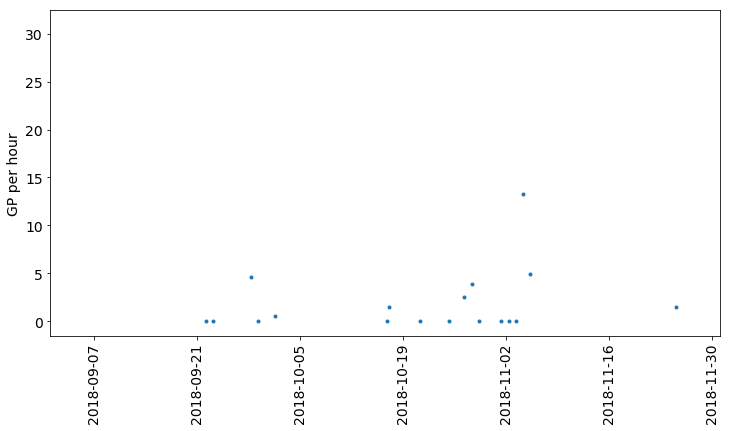

In [25]:
plt.figure(figsize=(12,6))
sort_ind = np.argsort(pd.to_datetime(concat_R.starttime))
plt.plot(pd.to_datetime(concat_R.starttime)[sort_ind], 
         concat_R.datapoints/(concat_R.n_images/60./60.)[sort_ind],".")
plt.xticks(rotation='vertical')
plt.ylabel("GP per hour")

plt.xlim([datetime.date(2018, 9, 1), 
          datetime.date(2018, 12, 1)])

# plt.xscale("log")

In [131]:
all_GP.to_csv("~/AS_PSR_all_GP.csv")

In [9]:
all_GP_db = pd.read_csv("~/AS_PSR_all_GP.csv")

(736322.94, 737797.06)

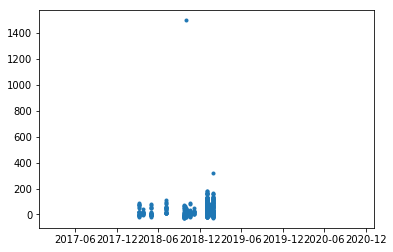

In [20]:
%matplotlib inline
sort_ind = np.argsort(pd.to_datetime(all_GP.taustart_ts))
plt.figure()
plt.plot(pd.to_datetime(all_GP.taustart_ts)[sort_ind], all_GP.f_int[sort_ind], ".")



plt.xlim([datetime.datetime(2019, 1, 1), 
          datetime.datetime(2019, 1, 1)])

In [39]:
for ind, GP_db in concat_R.iterrows():
    print GP_db.name

ASf_201803091515
ASf_201803251830
ASf_201803261842
ASf_201804141730
ASf_201804281040
ASf_201804301510
ASf_201807051014
ASf_20181103
ASf_20181104
ASf_20181105
ASf_201811250217
ASf_201812160230
ASf_20181231
ASf_20190101
ASf_20190113
ASf_20190117
ASf_20190118
ASf_20190126
ASf_20190127
ASf_20190129
ASf_201902232216
ASr_201609070340
ASr_201611120632
ASr_201611140501
ASr_201809220609
ASr_201809230412
ASr_201809280900
ASr_201809290600
ASr_201810170300
ASr_201810210800
ASr_20181024
ASr_20181025
ASr_20181026
ASr_20181027
ASr_20181028
ASr_20181029
ASr_20181101
ASr_20181102


### Get all GP and flux scale.

In [8]:

try:
    db._configured = False
    del db, session
except NameError:
    print "Clean"

Clean


In [9]:
ref_cat = pd.read_csv("~/AARTFAAC_catalogue.csv")

all_GP = pd.DataFrame({"f_int":[],"f_int_err":[],"det_sigma":[],
                       "ra":[],"decl":[],
                       "db":[],"id":[],
                       "band":[],"taustart_ts":[],"freq_eff":[]})

concat_R = pd.read_csv("~/All_PSR_db.csv")


for ind, GP_db in concat_R.iterrows():
    if GP_db.datapoints == 0.0:
        continue 
    
    print "name:", GP_db.db
    dataset = "1"

    logging.getLogger('sqlalchemy.engine').setLevel(query_loglevel)
    db = tkp.db.Database(engine=engine, host=host, port=port,
                         user=user, password=password, database=GP_db.db)

    db.connect()
    session = db.Session()

    transient_query = """
        SELECT ex.f_int, ex.f_int_err,
            ex.det_sigma, ex.extract_type, 
            ex.ra,
            ex.decl,
            im.band,
            im.taustart_ts,
            im.freq_eff
        FROM extractedsource ex, image im 
        WHERE ex.id IN ( SELECT xtrsrc FROM assocxtrsource WHERE runcat =  {})
        AND ex.image = im.id ORDER BY im.taustart_ts DESC;""".format(GP_db.id)


    GP_values = pd.DataFrame(run_query(transient_query, GP_db.db, 
                                       dataset, engine, host, port, user, password))
    
    db._configured = False
    del db, session
    
#     print GP_values


    if GP_db.db[:3] == "ASf":
        # get the points directly
        all_GP = all_GP.append(pd.DataFrame({"f_int":GP_values.f_int,
                                             "f_int_err":GP_values.f_int_err,
                                             "det_sigma":GP_values.det_sigma,
                                             "ra":GP_values.ra, "decl":GP_values.decl,
                                             "db":GP_db.db, "id":GP_db.id,
                                             "band":GP_values.band, "taustart_ts":GP_values.taustart_ts,
                                             "freq_eff":GP_values.freq_eff}))


    elif GP_db.db[:3] == "ASr":
        # Get the points and flux scale. 

        for gp_ind,raw_GP in GP_values.iterrows():

            db = tkp.db.Database(engine=engine, host=host, port=port,
                                 user=user, password=password, database=GP_db.db)

            db.connect()
            session = db.Session()


            transient_query = """SELECT ex.f_int, ex.f_int_err, ex.ra, ex.decl 
            FROM extractedsource ex 
            WHERE ex.image = (SELECT id FROM image 
            WHERE taustart_ts = '{}' AND band = {});""".format(raw_GP.taustart_ts,
                                                               raw_GP.band)


            image_pyse = pd.DataFrame(run_query(transient_query, GP_db.db, dataset, 
                                                engine, host, port, user, password))
            db._configured = False
            del db, session


            slope_cor, intercept_cor, ref_match, image_match, index_match = compare_flux(image_pyse,
                                               ref_cat["ra"],
                                               ref_cat["decl"],
                                               ref_cat["f_int"],
                                               ref_cat["f_int_err"])

            all_GP = all_GP.append(pd.DataFrame({"f_int":[(raw_GP.f_int - intercept_cor)/slope_cor],
                                         "f_int_err":[(raw_GP.f_int_err - intercept_cor)/slope_cor],
                                         "det_sigma":[raw_GP.det_sigma],
                                         "ra":[raw_GP.ra], "decl":[raw_GP.decl],
                                         "db":[GP_db.db], "id":[GP_db.id],
                                         "band":[raw_GP.band], "taustart_ts":[raw_GP.taustart_ts],
                                         "freq_eff":[raw_GP.freq_eff]}))






name: ASf_201803251830
name: ASf_201804141730
name: ASf_201804281040
name: ASf_201807051014
name: ASf_20181103
name: ASf_20181104
name: ASf_20181105
name: ASf_201812160230
name: ASf_20190101
name: ASf_20190117
name: ASf_20190126
name: ASf_20190127
name: ASr_201611120632
name: ASr_201611140501
name: ASr_201810170300
name: ASr_201810210800
name: ASr_20181024
name: ASr_20181025
name: ASr_20181026
name: ASr_20181027
name: ASr_20181028
name: ASr_20181101


In [11]:
all_GP.to_csv("~/AS_PSR_all_GP.csv")

In [ ]:
print len(all_GP), "giant pulses"

max: 3949.95252143 min 755.04458528
[  2.30852362e-04  -4.17157159e+00]


/afhome/kuiack/newtrap/local/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


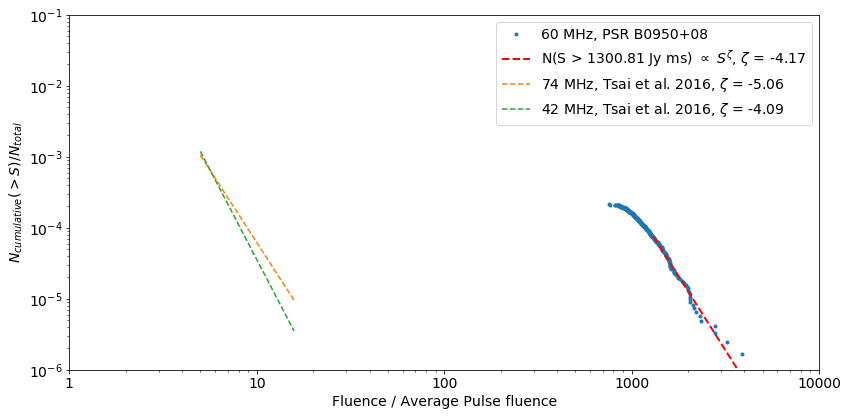

In [12]:
def powlaw(x,a,b):
    return a*x**b

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 14
       }

import matplotlib
from scipy.optimize import curve_fit

matplotlib.rc('font', **font)


from matplotlib.ticker import ScalarFormatter


x = (np.sort(all_GP.f_int.values) *1000.)/55.35

print "max:", np.max(x), "min", np.min(x)



y = np.array((np.array(range(len(all_GP.f_int.values))[::-1])))/(4.*concat_R.n_images.sum())

flux_limit = 72000/55.35

fit, cov = curve_fit(powlaw, x[(x > flux_limit)]/1000., y[(x > flux_limit)])

print fit

fig1, ax1 = plt.subplots(figsize=(12,6))

ax1.plot(x,y, ".", label="60 MHz, PSR B0950+08")

ax1.set_xscale("log")
ax1.set_yscale("log")
ax1.set_ylabel(r"$N_{cumulative}( > S)/N_{total}$")
ax1.set_xlabel("Fluence / Average Pulse fluence")
ax1.set_xlim([1,10000])
ax1.set_ylim([1e-6,0.1])

# ax1.set_xticks([50,80,100, 120,140] )

# for axis in [ax1.xaxis, ax1.yaxis]:
#     axis.set_major_formatter(ScalarFormatter())
ax1.xaxis.set_major_formatter(ScalarFormatter())

ax1.plot(x[(x > flux_limit)],
         powlaw(x[(x > flux_limit)]/1000.,fit[0],fit[1]), "--", c="r",lw =2, 
         label="N(S > {} Jy ms) "r"$\propto$"" "r"$S^\zeta$"", "r"$\zeta$"" = {}".format( round(flux_limit,2), 
                                                        round(fit[1],2), 
                                                        flux_limit))


ax1.plot(np.logspace(1,1.5)/2., powlaw(np.logspace(1,1.5),13., -4.09), "--", 
         label="74 MHz, Tsai et al. 2016, "r"$\zeta$ = -5.06"  )



ax1.plot(np.logspace(1,1.5)/2., powlaw(np.logspace(1,1.5),137., -5.06),"--", 
         label="42 MHz, Tsai et al. 2016, "r"$\zeta$ = -4.09")


ax1.legend()
plt.tight_layout()
# plt.savefig("/home/kuiack/Ngt60.png")


In [22]:
testdates = [i for i in pd.to_datetime(np.unique(times.taustart_ts.dt.round("1s")))]

In [19]:
times.taustart_ts.dt.round("1s")

In [33]:
% timeit

altaz = position.transform_to(AltAz(obstime=[i for i in pd.to_datetime(np.unique(times.taustart_ts.dt.round("1s")))],
                                    location=CS002))


In [29]:
print len(np.array(testdates))
print len(np.array(testdates)[(90.-altaz.alt.deg < 1.)])

13982
0


In [40]:
datetime.datetime.strftime(times.iloc[-1].values[1], format="%Y-%m-%d %H:%M:%S")

'2016-11-14 08:59:56'

In [43]:
pd.read_csv("~/PSR_0950_uptime.csv").timestamps.sum()*4

505772

In [37]:
psr = pd.read_csv("~/PSR_0950_uptime.csv")
allobs = pd.read_csv("/home/kuiack/survey_stats.csv")

In [39]:
allobs.obs

0     _201608311510
1     _201609051647
2     _201609070340
3     _201611120632
4     _201611132000
5     _201611140501
6     _201702241630
7     _201702250130
8     _201702250800
9     _201702251405
10    _201702260116
11    _201702260800
12    _201702261405
13    _201702270350
14    _201702280900
15    _201809212320
16    _201809220111
17    _201809220609
18    _201809221701
19    _201809230412
20    _201809280900
21    _201809281701
22    _201809290600
23    _201810162000
24    _201810170300
25    _201810210800
26    _201810211605
27        _20181024
28        _20181025
29        _20181026
30        _20181027
31        _20181028
32        _20181029
33        _20181101
34        _20181102
35     ASf_20181103
36     ASf_20181104
37     ASf_20181105
38     ASf_20181231
39     ASf_20190101
Name: obs, dtype: object

In [41]:
# for obs in psr[psr.timestamps > 0].obs:
for obs in allobs.obs:
    
    dbname = obs
    dataset = 1
#     print dbname, dataset
#     print "database name: ",  dbname
    logging.getLogger('sqlalchemy.engine').setLevel(query_loglevel)

    db = tkp.db.Database(engine=engine, host=host, port=port,
                     user=user, password=password, database=dbname)

    db.connect()
    session = db.Session()

    transients_query = """
        SELECT id FROM runningcatalog 
        WHERE runningcatalog.wm_ra >= 53.
        AND runningcatalog.wm_ra <= 54. 
        AND runningcatalog.wm_decl >= 54 
        AND runningcatalog.wm_decl <= 55 ;
        """
    PSR_runcat_ids = pd.DataFrame(run_query(transients_query, dbname, dataset, engine, host, port, user, password))
    
    db._configured = False
    del db, session
    if len(PSR_runcat_ids.keys()) >= 1:
        print dbname, PSR_runcat_ids.id.values
    

Found 0 new sources
Found 0 new sources
Found 1 new sources
_201609070340 [4448]
Found 0 new sources
Found 0 new sources
Found 0 new sources
Found 0 new sources
Found 0 new sources
Found 2 new sources
_201702250800 [4846 4847]
Found 0 new sources
Found 0 new sources
Found 0 new sources
Found 0 new sources
Found 0 new sources
Found 0 new sources
Found 0 new sources
Found 0 new sources
Found 0 new sources
Found 0 new sources
Found 0 new sources
Found 0 new sources
Found 0 new sources
Found 1 new sources
_201809290600 [573]
Found 0 new sources
Found 0 new sources
Found 0 new sources
Found 0 new sources
Found 0 new sources
Found 0 new sources
Found 0 new sources
Found 0 new sources
Found 0 new sources
Found 0 new sources
Found 0 new sources
Found 0 new sources
Found 0 new sources
Found 0 new sources
Found 0 new sources
Found 0 new sources
Found 0 new sources


In [20]:
PSR_runcat_ids.keys()

Index([], dtype='object')

### Retrieve monitor sources

In [70]:
AS_db = "AS_PSR_20180414"
dataset = "1"


logging.getLogger('sqlalchemy.engine').setLevel(query_loglevel)

db = tkp.db.Database(engine=engine, host=host, port=port,
                     user=user, password=password, database=AS_db)

db.connect()
session = db.Session()

transients_query = """
    SELECT                                                  
        ex.f_int, ex.f_int_err, ex.f_peak,
        ex.det_sigma, 
        ex.ra, 
        ex.decl, 
        im.band, 
        im.taustart_ts,
        im.freq_eff,
        im.url,
        ax.runcat
    FROM 
        extractedsource ex, 
        image im,
        assocxtrsource ax
    WHERE ex.id = ax.xtrsrc
    AND ex.image = im.id
    """

obs_data = pd.DataFrame(run_query(transients_query, AS_db, dataset, engine, host, port, user, password))

db._configured = False
del db, session

#     print "\t", obs_len

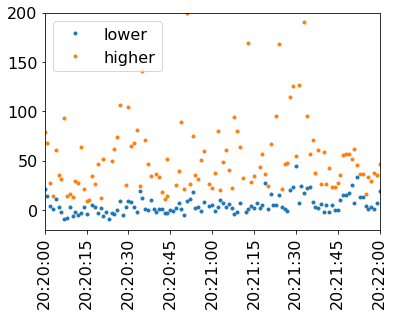

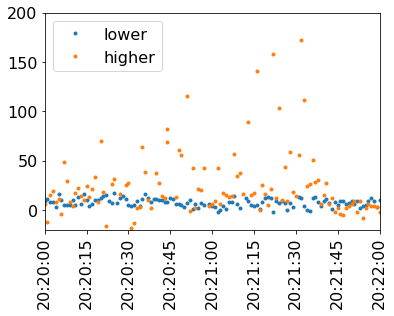

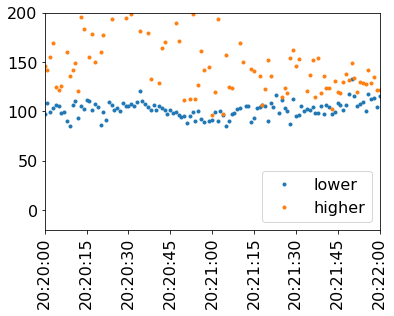

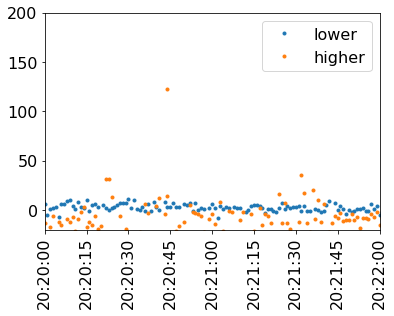

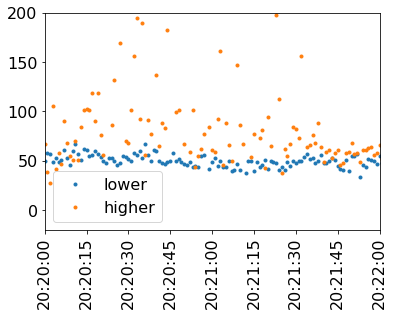

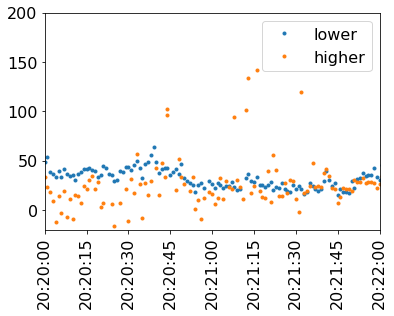

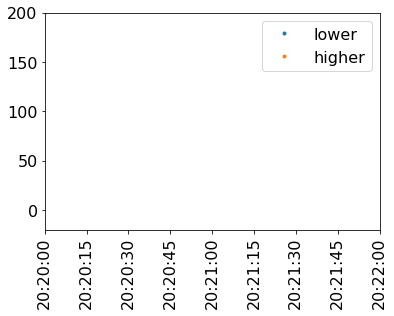

In [48]:

for i in [1,2,3,4,5,6,7]:
    plt.figure()
    plt.plot(pd.to_datetime(obs_data[(obs_data.runcat ==i) & (obs_data.freq_eff < 60000000)].taustart_ts),
         obs_data[(obs_data.runcat ==i) & (obs_data.freq_eff < 60000000 )].f_int, ".", label="lower")
    plt.plot(pd.to_datetime(obs_data[(obs_data.runcat ==i) & (obs_data.freq_eff > 60000000)].taustart_ts),
         obs_data[(obs_data.runcat ==i) & (obs_data.freq_eff > 60000000 )].f_int, ".", label="higher")


# plt.plot(pd.to_datetime(obs_data[(obs_data.runcat ==1) & (obs_data.freq_eff > 60000000)].taustart_ts),
#          obs_data[(obs_data.runcat ==1) & (obs_data.freq_eff > 60000000 )].f_int, ".")
    plt.ylim([-20,200])
    plt.ylim([-20,200])
    plt.xticks(rotation="vertical")
    plt.xlim([datetime.datetime(2018, 4, 14, 20, 20),
              datetime.datetime(2018, 4, 14, 20, 22)])
    plt.legend()

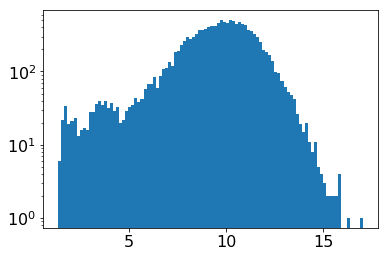

In [86]:
x = plt.hist(obs_data[(obs_data.runcat == 1) & \
                      (obs_data.freq_eff > 60000000 )].det_sigma, 
             bins=100, log=True)

In [98]:
data_ind = (obs_data.url == '/mnt/ais001/ASf_201804141730/2018-04-14T18:00:00-S298.5-B8.fits')

# plt.scatter( obs_data[data_ind].ra,obs_data[data_ind].decl,
#             c=20*obs_data[data_ind].f_peak/obs_data[data_ind].det_sigma)




CS002 = EarthLocation.from_geocentric (3826577.109500000, 461022.900196000, 5064892.758, 'm')


list_ra = [x*u.degree for x in obs_data[data_ind].ra]
list_decl = [x*u.degree for x in obs_data[data_ind].decl]

position = SkyCoord(list_ra, list_decl)


obs_times = [i for i in pd.to_datetime(np.unique(obs_data[data_ind].taustart_ts.dt.round("1s")))]


altaz = position.transform_to(AltAz(obstime=obs_times, location=CS002))


# plt.scatter( altaz.alt.deg, obs_data[data_ind].decl,
#             c=20*obs_data[data_ind].f_peak/obs_data[data_ind].det_sigma)


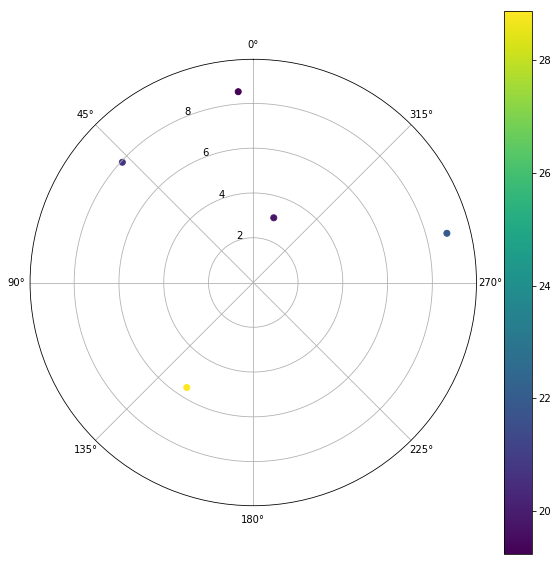

In [129]:
%matplotlib inline

min_r = 10

plt.figure(figsize=(10,10))
ax = plt.subplot(projection="polar")
plt.scatter( altaz.az.rad[(90-altaz.alt.deg) < min_r], 
            (90-altaz.alt.deg)[(90-altaz.alt.deg) < min_r], 
            c=3*(obs_data[data_ind].f_peak/obs_data[data_ind].det_sigma)[(90-altaz.alt.deg) < min_r])

ax.set_theta_zero_location("N")
plt.colorbar()

In [132]:
print (obs_data[data_ind].f_peak)[(90-altaz.alt.deg) < 10]
print 3*(obs_data[data_ind].f_peak/obs_data[data_ind].det_sigma)[(90-altaz.alt.deg) < min_r]

15     63.483778
21     38.043284
22     45.666119
68    192.002290
90     24.596401
Name: f_peak, dtype: float64
15    21.934268
21    20.733030
22    19.829803
68    28.875626
90    19.234336
dtype: float64


### number of detections of a given signicicance vs. number of images,

are these just the tail of a distribution? 

In [ ]:
"""SELECT ex.f_int, ex.f_int_err,ex.f_peak, 
    ex.det_sigma, extract_type, 
    ex.ra, 
    ex.decl, 
    im.band, 
    im.taustart_ts, im.url 
    FROM extractedsource ex, image im 
    WHERE ex.id IN ( select xtrsrc FROM assocxtrsource WHERE runcat = 4448) 
    AND ex.image = im.id
    ORDER BY ex.det_sigma DESC;
    """


In [8]:
AS_db = "A12_20190303"
dataset = "1"


logging.getLogger('sqlalchemy.engine').setLevel(query_loglevel)

db = tkp.db.Database(engine=engine, host=host, port=port,
                     user=user, password=password, database=AS_db)

db.connect()
session = db.Session()

transients_query = """
    SELECT id, wm_ra, wm_decl, datapoints FROM runningcatalog WHERE 
        runningcatalog.wm_ra >= 178. AND 
        runningcatalog.wm_ra <= 179. AND 
        runningcatalog.wm_decl >= 54. AND 
        runningcatalog.wm_decl <= 55.
    """

obs_GP = pd.DataFrame(run_query(transients_query, AS_db, dataset, engine, host, port, user, password))


print "database name: ",  AS_db
print obs_GP.id.values
obs_GP["db"] = AS_db
all_GP_db = all_GP_db.append(obs_GP)

db._configured = False
del db, session

obs_GP.sort_values("datapoints")
#     print "\t", obs_len

database name:  A12_20190303
[  199   986  7200  2088   275    40   792  5700   604  1048   475  1399
  1581 16756   355  5941  1243  1771   418  3301   128  1111   851  2202
   542  3088  1711  6171  1457   672  1651  2874   920  2037  1304  1174
  2471  1520  1861  4454   728  2146  1979  2255  2530  2633  2689  2926
  1922  2818  2307  2986  3748  2745  2363  3191  3646  2415  2579  6298
  3429  3142  3495  3378  6660  3243  5581  5013  3541  4610  3598  6415
  4516  3886  5408  4154  3834  5164  4730  4950  3979  5105  4260  5466
  6054  5225  5763 13894  5343  9382  6239  5876  5522  5287  5820  6775
  5639 10078  6114  7138  6358 12713  6000  8382  6476  7012  6835  7072
  6592 14676  6534 14961  6889  6720  6950  7267  7645  7706  7327  7394
  7584  8452  7458  7518  7838  9115  7899  9467  8969  7766  9042  7998
  8515 17847 18047  8253  8318  8068  8130  8901  8187  8837 16058  9312
 17130 12984  8643 17911 17980  8714 10190  8771  8585  9581 15293  9188
 11362  9639  9247  95

,datapoints,id,wm_decl,wm_ra,db
0,2,199,54.892532,178.830115,A12_20190303
169,2,10751,54.877939,178.794350,A12_20190303
170,2,10804,54.855547,178.822142,A12_20190303
171,2,10358,54.897896,178.809077,A12_20190303
172,2,14413,54.890163,178.854438,A12_20190303
173,2,11477,54.895428,178.806962,A12_20190303
174,2,10698,54.880308,178.804657,A12_20190303
175,2,10416,54.872687,178.791588,A12_20190303
176,2,10533,54.873487,178.798858,A12_20190303
177,2,10477,54.873794,178.811392,A12_20190303


### Flux calibrate in DB

In [66]:
dbname = "_201611132000"
dataset = 1
#     print dbname, dataset
#     print "database name: ",  dbname
logging.getLogger('sqlalchemy.engine').setLevel(query_loglevel)

db = tkp.db.Database(engine=engine, host=host, port=port,
                 user=user, password=password, database=dbname)

db.connect()
session = db.Session()

transients_query = """SELECT ex.f_int, ex.f_int_err, ex.ra, ex.decl 
FROM extractedsource ex 
WHERE ex.image = (SELECT id FROM image WHERE taustart_ts = '2016-11-13 20:00:21.619' AND band = 24);"""

image_pyse = pd.DataFrame(run_query(transients_query, dbname, dataset, engine, host, port, user, password))

db._configured = False
del db, session


Found 73 new sources


/afhome/kuiack/newtrap/lib/python2.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log10
  """Entry point for launching an IPython kernel.


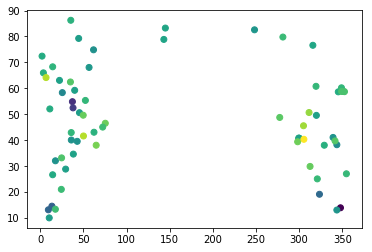

In [67]:
plt.scatter(image_pyse.ra,image_pyse.decl, c=np.log10(image_pyse.f_int))

In [7]:
def distSquared(p0, p1):
    '''
    Calculate the distance between point p0, [x,y], and a list of points p1, [[x0..xn],[y0..yn]]. 
    '''
    distance  = np.sqrt((p0[0] - p1[0,:])**2 + (p0[1] - p1[1,:])**2)
    if np.min(distance) < 1.0:
        return np.where(distance == np.min(distance))[0]
    else:
        return None

def pol2cart(rho, phi):
    """
    Polar to Cartesian coordinate conversion, for distance measure around celestial pole.
    """
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return(x, y)

def compare_flux(sr, catalog_ras, catalog_decs, catalog_fluxs, catalog_flux_errs):
    '''
    Compares the two catalogues, matching sources, and outputs the results of linear fit to the fluxes. 
    '''
    x = []
    y = []

    w = []
    sr_indexes = []
    cat_indexes = []


    for i in range(len(sr)):

        sr_x, sr_y = pol2cart(np.abs(90-sr.iloc[i].decl),
                np.deg2rad(sr.iloc[i].ra))

        cat_x, cat_y = pol2cart(np.abs(90-catalog_decs),
                np.deg2rad(catalog_ras))

        index = distSquared((sr_x,sr_y),
                   np.array([cat_x, cat_y]))

        if type(index) == np.ndarray:
            flux = catalog_fluxs[index]
            flux_err = catalog_flux_errs[index]

            cat_indexes.append(index)
            sr_indexes.append(i)
            y.append(float(sr.iloc[i].f_int))
            x.append(float(flux))
            w.append(float(sr.iloc[i].f_int_err))
        else:
            continue
            
    if len(x) > 2:
        w = np.array(w,dtype=float)
        fit = np.polyfit(x,y,1,w=1./w)
    else:
        fit = [1e9,1e9]

    return fit[0], fit[1]




In [69]:
ref_cat = pd.read_csv("~/AARTFAAC_catalogue.csv")

slope_cor, intercept_cor = compare_flux(image_pyse,
                                       ref_cat["ra"],
                                       ref_cat["decl"],
                                       ref_cat["f_int"],
                                       ref_cat["f_int_err"])

In [70]:
print slope_cor, intercept_cor

1.66783999995 8.24990832664


In [78]:
for i in range(len(image_pyse.f_int)):
    print (image_pyse.iloc[i].f_int- intercept_cor)/slope_cor, image_pyse.iloc[i].ra, image_pyse.iloc[i].decl

43.8268919373 248.320319563 82.5828355717
51.423244475 45.375890415 50.5910973229
32.4667433457 343.769229672 38.2147480897
11.466642275 9.33354032717 13.0882306606
57.0890909261 22.24018133 63.0617748736
49.87832747 10.3465887931 9.96728694655
-5.46631753189 36.8741749291 28.0154887323
-5.87252781496 95.8518262839 71.5137043608
30.3084596406 25.5140522168 58.332866017
-37.4043772744 354.325009505 57.1113004148
42.8388937584 351.157008656 58.8255502618
-8.19852977727 347.669840205 60.4345261875
-2.20068547679 347.969838059 13.8662037391
13.0139955802 323.602823919 19.0842583564
39.2226399349 339.361666799 41.0319681564
59.4108918159 300.103092886 40.7163197247
74.6955608164 299.5123121 40.7785496343
-9.7132887652 341.635997119 14.2031027784
-14.6276620228 286.60979915 73.89872368
-25.6864005149 350.795450171 29.5823027396
10.177770196 13.4375321057 14.4915135999
57.8734142447 320.046077254 49.5462588247
52.574917023 44.4769080499 79.2577022613
37.8001998657 61.6975801571 74.8615844276


In [81]:
# image_pyse.f_int = (image_pyse.f_int - intercept_cor)/slope_cor
image_pyse.f_int_err = (image_pyse.f_int_err - intercept_cor)/slope_cor

In [82]:
image_pyse.to_csv("~/DB_fluxfit.csv")